# Meaningful Question 3:

## Does paying more for a house get you more quantity (bedrooms, bathrooms, sqft) or quality (condition, grade)?

## Imports

In [2]:
import pandas as pd
import numpy as np
from helpers import *
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn')

df = pd.read_csv("kc_house_data.csv")

## Data Cleaning

In [3]:
# Creating a new dataframe with only these seven columns
more_df = df.filter(["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "condition", "grade"])

In [4]:
# Removing an obvious, problematic outlier with 33 bedrooms
more_df = more_df.where(more_df["bedrooms"] < 32)
# Sanity Check:
# more_df.loc[more_df['bedrooms'] > 30]

In [5]:
# Adding a Total Square Feet column to show the combined sqft of living space
# and the lot around the home
more_df["total_sqft"] = more_df["sqft_living"] + more_df["sqft_lot"]

In [6]:
more_df.dtypes

price          float64
bedrooms       float64
bathrooms      float64
sqft_living    float64
sqft_lot       float64
condition      float64
grade          float64
total_sqft     float64
dtype: object

In [8]:
# Creating variables for each column
# Also creating variables to log the continuous variables

price = more_df["price"]
bedrooms = more_df["bedrooms"]
bathrooms = more_df["bathrooms"]
sqft_living = more_df["sqft_living"]
sqft_lot = more_df["sqft_lot"]
condition = more_df["condition"]
grade = more_df["grade"]
total_sqft = more_df["total_sqft"]

price_log = np.log(price)
sqft_living_log = np.log(sqft_living)
sqft_lot_log = np.log(sqft_lot)
total_sqft_log = np.log(total_sqft)

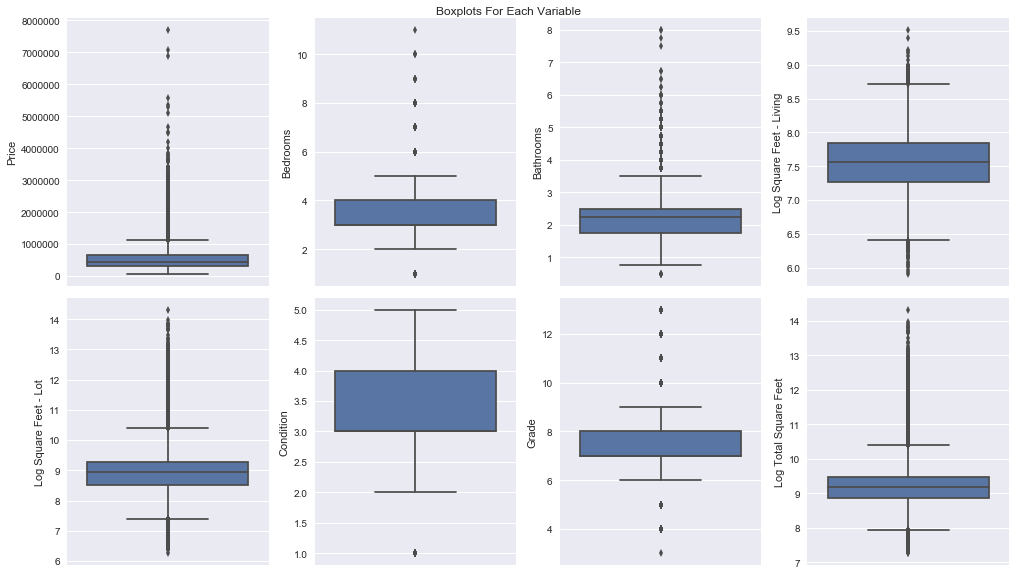

In [6]:
# Creating boxplots for each variable
f1, axes = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)

ax1_0_0 = sns.boxplot(price, orient='v', ax=axes[0,0])
ax1_0_1 = sns.boxplot(bedrooms, orient='v', ax=axes[0,1])
ax1_0_2 = sns.boxplot(bathrooms, orient='v', ax=axes[0,2])
ax1_0_3 = sns.boxplot(sqft_living_log, orient='v', ax=axes[0,3])
ax1_1_0 = sns.boxplot(sqft_lot_log, orient='v', ax=axes[1,0])
ax1_1_1 = sns.boxplot(condition, orient='v', ax=axes[1,1])
ax1_1_2 = sns.boxplot(grade, orient='v', ax=axes[1,2])
ax1_1_3 = sns.boxplot(total_sqft_log, orient='v', ax=axes[1,3])

ax1_0_0.set_ylabel("Price")
ax1_0_1.set_ylabel("Bedrooms")
ax1_0_2.set_ylabel("Bathrooms")
ax1_0_3.set_ylabel("Log Square Feet - Living")
ax1_1_0.set_ylabel("Log Square Feet - Lot")
ax1_1_1.set_ylabel("Condition")
ax1_1_2.set_ylabel("Grade")
ax1_1_3.set_ylabel("Log Total Square Feet")

f1.suptitle("Boxplots For Each Variable")

plt.show()

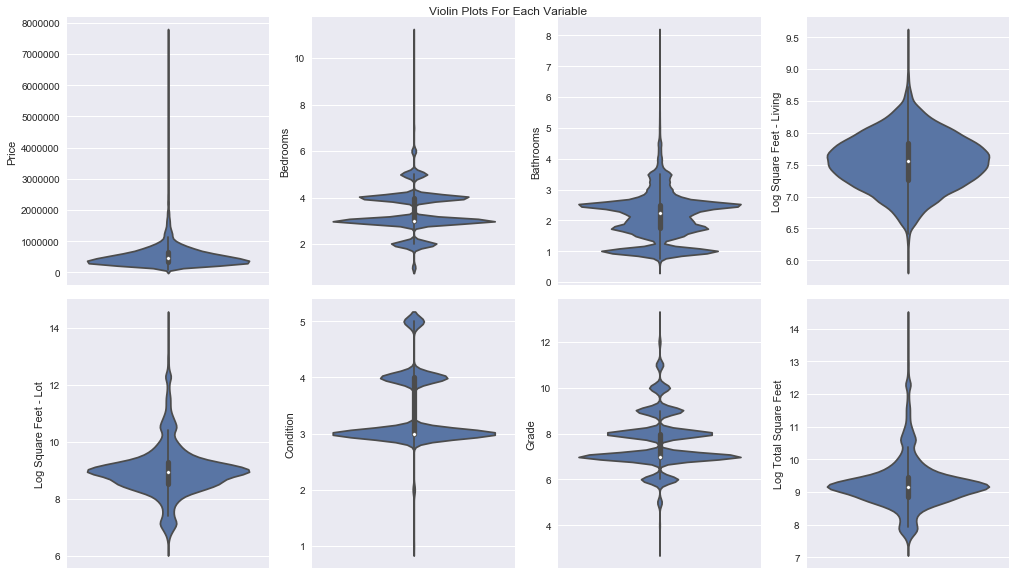

In [7]:
# Creating violinplots (oooh) for each variable
f2, axes = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)

ax2_0_0 = sns.violinplot(price, orient='v', ax=axes[0,0])
ax2_0_1 = sns.violinplot(bedrooms, orient='v', ax=axes[0,1])
ax2_0_2 = sns.violinplot(bathrooms, orient='v', ax=axes[0,2])
ax2_0_3 = sns.violinplot(sqft_living_log, orient='v', ax=axes[0,3])
ax2_1_0 = sns.violinplot(sqft_lot_log, orient='v', ax=axes[1,0])
ax2_1_1 = sns.violinplot(condition, orient='v', ax=axes[1,1])
ax2_1_2 = sns.violinplot(grade, orient='v', ax=axes[1,2])
ax2_1_3 = sns.violinplot(total_sqft_log, orient='v', ax=axes[1,3])

ax2_0_0.set_ylabel("Price")
ax2_0_1.set_ylabel("Bedrooms")
ax2_0_2.set_ylabel("Bathrooms")
ax2_0_3.set_ylabel("Log Square Feet - Living")
ax2_1_0.set_ylabel("Log Square Feet - Lot")
ax2_1_1.set_ylabel("Condition")
ax2_1_2.set_ylabel("Grade")
ax2_1_3.set_ylabel("Log Total Square Feet")

f2.suptitle("Violin Plots For Each Variable")

plt.show()

#### Splitting data frame into four equal parts, based on quartiles

In [8]:
# Sorting and qcutting in order to arrive at ranges for quartiles
more_df = more_df.sort_values(by="price")
pd.qcut(more_df["price"], 4).value_counts()

(322000.0, 450000.0]     5445
(77999.999, 322000.0]    5406
(450000.0, 645000.0]     5374
(645000.0, 7700000.0]    5371
Name: price, dtype: int64

In [9]:
# Creating a new Quartile column
more_df.loc[more_df["price"] <= 323000, "quartile"] = 1
more_df.loc[more_df["price"].between(322000.1, 450000.0, inclusive=True), "quartile"] = 2
more_df.loc[more_df["price"].between(450000.1, 645000.0, inclusive=True), "quartile"] = 3
more_df.loc[more_df["price"] > 645000, "quartile"] = 4

In [10]:
# Creating new dataframes for each quartile, based on price
lowest_df = more_df.loc[more_df["price"] <= 322000.0]
second_df = more_df.loc[more_df["price"].between(322000.1, 450000.0, inclusive=True)]
third_df = more_df.loc[more_df["price"].between(450000.1, 645000.0, inclusive=True)]
highest_df = more_df.loc[more_df["price"] > 645000.0]

#### Creating and melting quality and quantity columns

In [11]:
quantity_df = more_df.filter(["price", "bedrooms", "bathrooms", "quartile"])

# Melting quantity columns (bedrooms, bathrooms and total_sqft) into one column
melted_quantity_df = pd.melt(quantity_df,
                            id_vars=["price", "quartile"],
                            var_name="quantity")

In [12]:
quality_df = more_df.filter(["price", "condition", "grade", "quartile"])

# Melting quality columns (condition, grade) into one column
melted_quality_df = pd.melt(quality_df,
                            id_vars=["price", "quartile"],
                            var_name="quality")
melted_quality_df.head(10)

,price,quartile,quality,value
0,78000.0,1.0,condition,1.0
1,80000.0,1.0,condition,2.0
2,81000.0,1.0,condition,1.0
3,82000.0,1.0,condition,3.0
4,82500.0,1.0,condition,2.0
5,83000.0,1.0,condition,3.0
6,84000.0,1.0,condition,3.0
7,85000.0,1.0,condition,3.0
8,85000.0,1.0,condition,3.0
9,86500.0,1.0,condition,3.0


## Analyzing

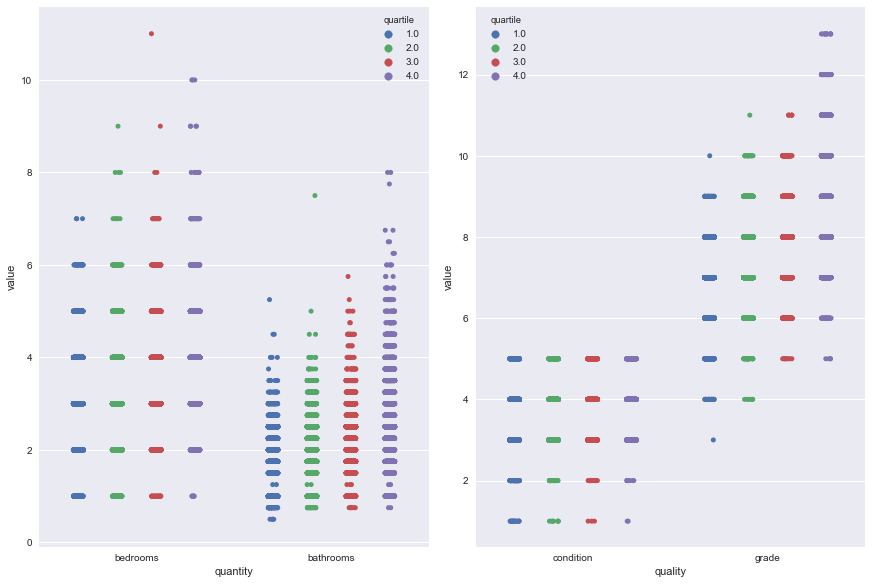

In [13]:
f3, axes = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax3_0 = sns.stripplot(x="quantity", 
                      y="value", 
                      hue="quartile", 
                      data=melted_quantity_df,
                      dodge=True,
                      ax=axes[0])
ax3_1 = sns.stripplot(x="quality", 
                      y="value", 
                      hue="quartile", 
                      data=melted_quality_df,
                      dodge=True,
                      ax=axes[1])

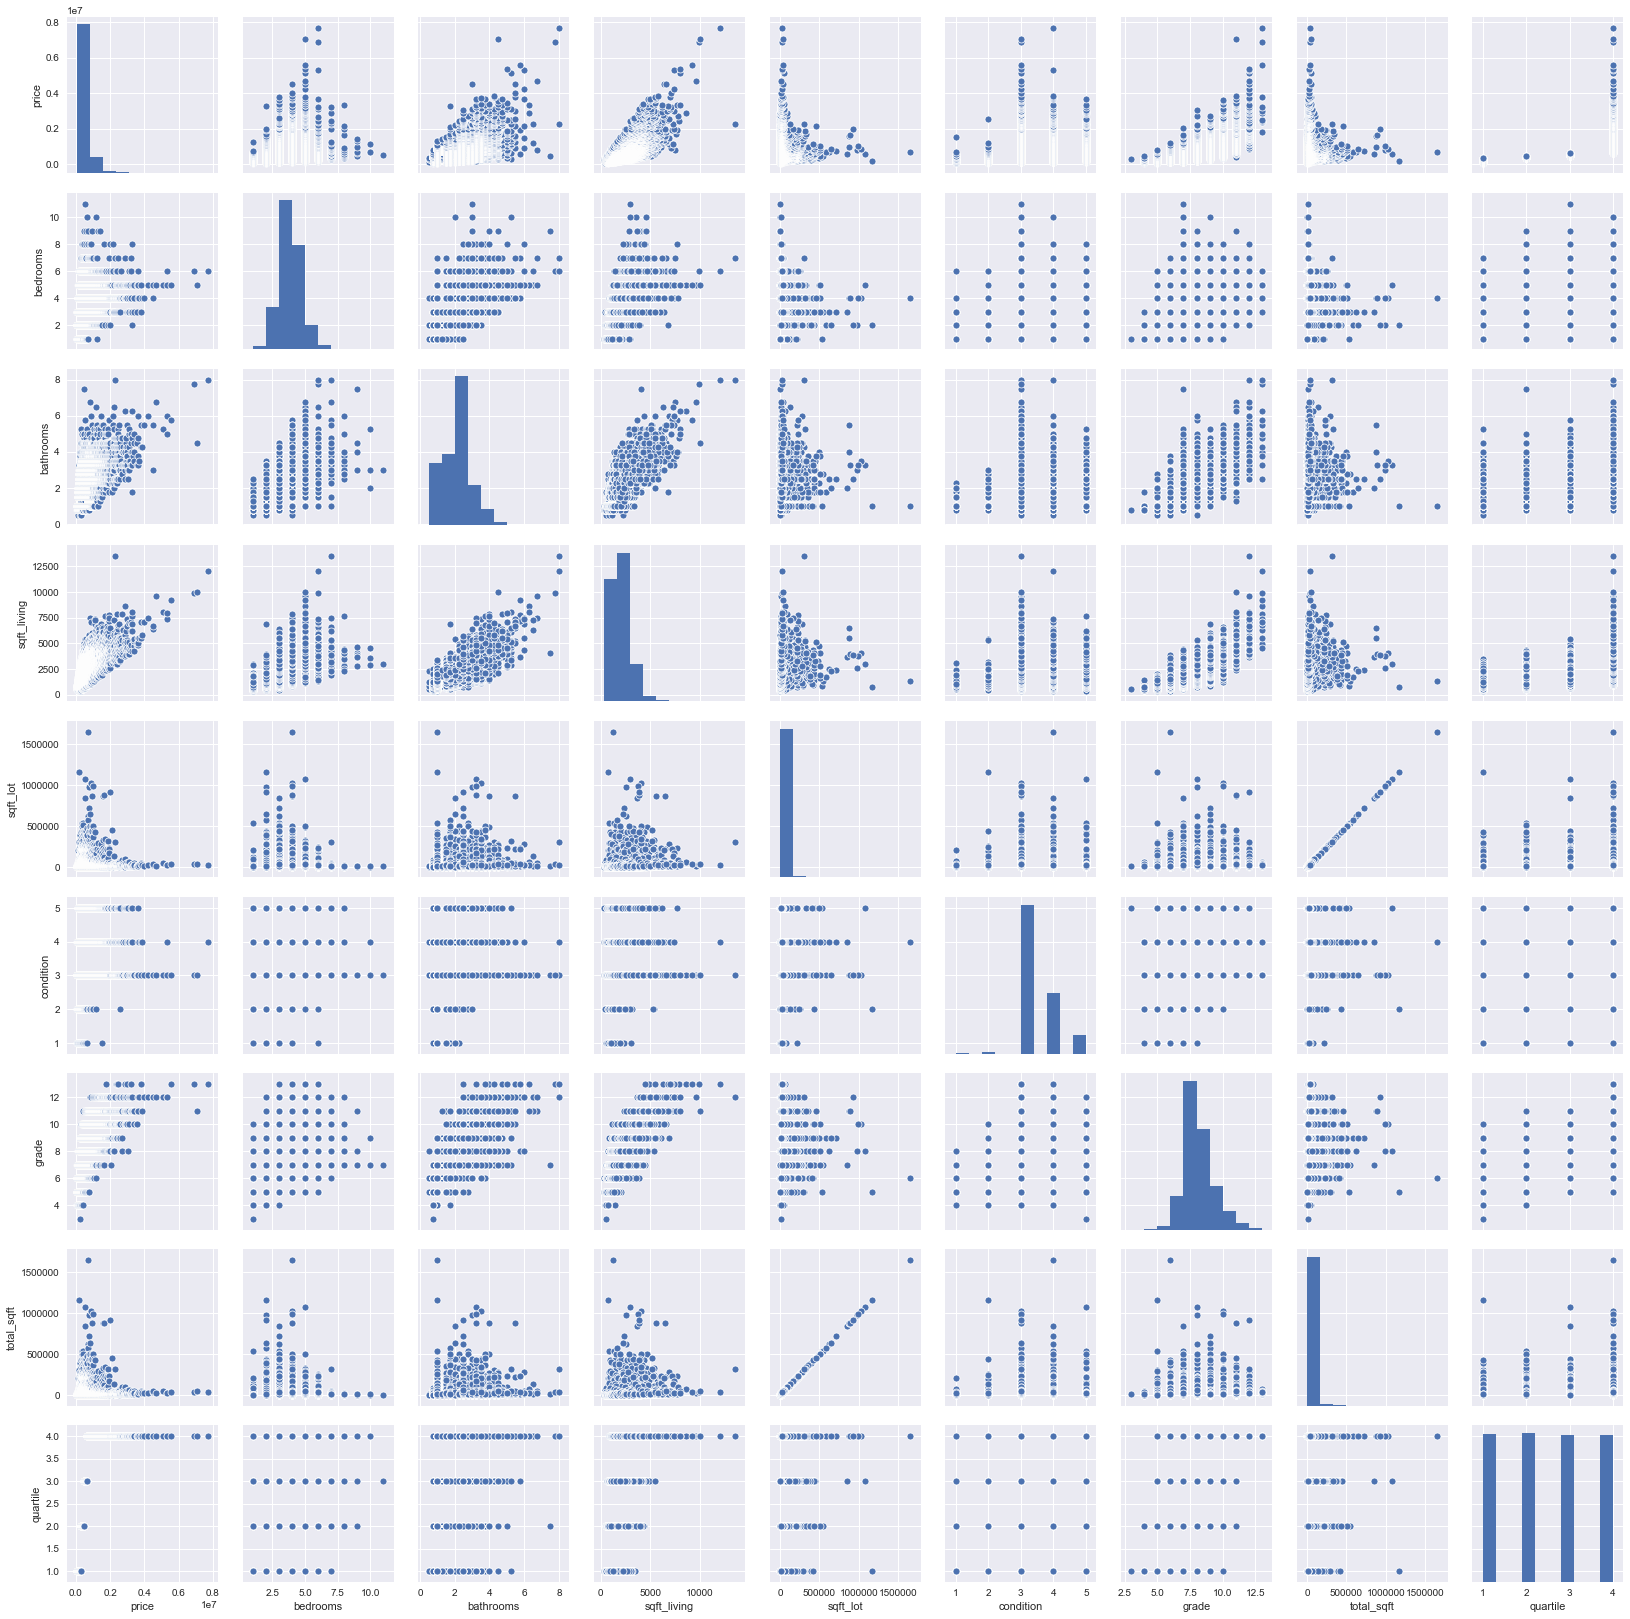

In [24]:
sns.pairplot(more_df)

In [14]:
# Describing the original dataframe
more_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,total_sqft,quartile
count,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04,21596.000000,21596.000000,2.159600e+04,21596.000000
mean,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04,3.409752,7.657946,1.718017e+04,2.495925
std,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04,0.650471,1.173218,4.158263e+04,1.117182
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,1.423000e+03,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,3.000000,7.000000,7.035750e+03,1.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,3.000000,7.000000,9.575000e+03,2.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04,4.000000,8.000000,1.299600e+04,3.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,5.000000,13.000000,1.652659e+06,4.000000


In [15]:
# Describing the lowest (least expensive) data set
lowest_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,total_sqft,quartile
count,5406.000000,5406.000000,5406.000000,5406.000000,5.406000e+03,5406.000000,5406.000000,5.406000e+03,5406.0
mean,251769.994451,3.035886,1.664169,1466.555494,1.043615e+04,3.410655,6.805031,1.190270e+04,1.0
std,48252.198518,0.799750,0.614905,470.464384,2.335747e+04,0.661390,0.727230,2.336106e+04,0.0
min,78000.000000,1.000000,0.500000,370.000000,5.720000e+02,1.000000,3.000000,1.423000e+03,1.0
25%,220000.000000,3.000000,1.000000,1110.000000,6.000000e+03,3.000000,6.000000,7.339250e+03,1.0
50%,259000.000000,3.000000,1.750000,1420.000000,7.788500e+03,3.000000,7.000000,9.316500e+03,1.0
75%,290000.000000,3.000000,2.250000,1780.000000,9.727500e+03,4.000000,7.000000,1.127000e+04,1.0
max,322000.000000,7.000000,5.250000,3490.000000,1.164794e+06,5.000000,10.000000,1.165504e+06,1.0


In [16]:
# Describing the second-lowest (second least expensive) data set
second_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,total_sqft,quartile
count,5445.000000,5445.000000,5445.000000,5445.000000,5445.000000,5445.000000,5445.000000,5445.000000,5445.0
mean,385844.123232,3.229201,1.959596,1780.336272,12773.881726,3.363085,7.294582,14554.217998,2.0
std,38326.892242,0.855242,0.644148,595.619319,31692.163729,0.611724,0.750152,31746.532019,0.0
min,322200.000000,1.000000,0.750000,410.000000,600.000000,1.000000,4.000000,1501.000000,2.0
25%,350000.000000,3.000000,1.500000,1330.000000,4800.000000,3.000000,7.000000,6439.000000,2.0
50%,385000.000000,3.000000,2.000000,1730.000000,7255.000000,3.000000,7.000000,9051.000000,2.0
75%,420000.000000,4.000000,2.500000,2180.000000,9784.000000,4.000000,8.000000,11750.000000,2.0
max,450000.000000,9.000000,7.500000,4340.000000,542322.000000,5.000000,11.000000,543682.000000,2.0


In [17]:
# Describing the third lowest (second most expensive) data set
third_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,total_sqft,quartile
count,5374.000000,5374.000000,5374.000000,5374.000000,5.374000e+03,5374.000000,5374.000000,5.374000e+03,5374.0
mean,539722.672311,3.402493,2.169613,2083.433755,1.588809e+04,3.403982,7.698362,1.797153e+04,3.0
std,54332.004054,0.873585,0.638598,661.268253,4.002362e+04,0.635795,0.811242,4.014966e+04,0.0
min,450500.000000,1.000000,0.750000,680.000000,6.380000e+02,1.000000,5.000000,1.738000e+03,3.0
25%,494000.000000,3.000000,1.750000,1600.000000,4.521750e+03,3.000000,7.000000,6.280000e+03,3.0
50%,537000.000000,3.000000,2.250000,2020.000000,7.185500e+03,3.000000,8.000000,9.249500e+03,3.0
75%,585000.000000,4.000000,2.500000,2490.000000,1.068725e+04,4.000000,8.000000,1.298550e+04,3.0
max,645000.000000,11.000000,5.750000,5461.000000,1.074218e+06,5.000000,11.000000,1.077228e+06,3.0


In [18]:
# Describing the highest (most expensive) data set
highest_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,total_sqft,quartile
count,5.371000e+03,5371.000000,5371.000000,5371.000000,5.371000e+03,5371.000000,5371.000000,5.371000e+03,5371.0
mean,9.878394e+05,3.823869,2.675061,2999.178551,2.136319e+04,3.461925,8.844349,2.436237e+04,4.0
std,4.771142e+05,0.893738,0.789327,1027.105896,6.049521e+04,0.687337,1.224051,6.068210e+04,0.0
min,6.455000e+05,1.000000,0.750000,890.000000,5.200000e+02,1.000000,5.000000,2.080000e+03,4.0
25%,7.235000e+05,3.000000,2.250000,2330.000000,5.400000e+03,3.000000,8.000000,8.120000e+03,4.0
50%,8.260000e+05,4.000000,2.500000,2880.000000,8.580000e+03,3.000000,9.000000,1.163000e+04,4.0
75%,1.050000e+06,4.000000,3.250000,3510.000000,1.434750e+04,4.000000,10.000000,1.787600e+04,4.0
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,5.000000,13.000000,1.652659e+06,4.0


In [19]:
# Creating a dataframe for quantity variables, using the log of total square feet
quantity_df = pd.DataFrame()
quantity_df["price"] = price
quantity_df["bedrooms"] = bedrooms
quantity_df["bathrooms"] = bathrooms
quantity_df["total_sqft_log"] = total_sqft_log

# Modeling our quantity variables against target Price
quantity_model = ols(formula=('price~bedrooms+bathrooms+total_sqft_log'), data=quantity_df).fit()
quantity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     2977.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        14:38:21   Log-Likelihood:            -3.0364e+05
No. Observations:               21596   AIC:                         6.073e+05
Df Residuals:                   21592   BIC:                         6.073e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.297e+05   2.53e+04    -20.918      0.000   -5.79e+05    -4.8e+05
bedrooms        1.225e+04   2775.556      4.413      0.000    6808.683    1.77e+04
bathrooms       2.327e+05   3229.213     72.056      0.000    2.26e+05    2.39e+05
total_sqft_log  5.796e+04   2805.669     20.660      0.000    5.25e+04    6.35e+04
==============================================================================
Omnibus:                    17293.463   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           898572.911
Skew:                           3.460   Prob(JB):                         0.00
Kurtosis:                      33.833   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Creating a dataframe for quality variables
quality_df = more_df[["price", "condition", "grade"]]

# Modeling our quality variables against target Price
quality_model = ols(formula=('price~condition+grade'), data=quality_df).fit()
quality_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     9367.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        14:38:21   Log-Likelihood:            -3.0063e+05
No. Observations:               21596   AIC:                         6.013e+05
Df Residuals:                   21593   BIC:                         6.013e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.374e+06   1.67e+04    -82.474      0.000   -1.41e+06   -1.34e+06
condition   7.742e+04   2843.254     27.230      0.000    7.18e+04     8.3e+04
grade       2.155e+05   1576.393    136.683      0.000    2.12e+05    2.19e+05
==============================================================================
Omnibus:                    20147.765   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2218082.130
Skew:                           4.152   Prob(JB):                         0.00
Kurtosis:                      51.949   Cond. No.                         78.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary: